In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import fftpack
from scipy import signal

In [172]:
sampling_rate = 4000
gain = 12
v_ref = 4.5
resolution = (2**23) - 1

In [218]:
channel_offset = np.load('data/channel_offset_internal.npy')
df = pd.DataFrame(data=channel_offset.T).set_index(0)
df = (df * v_ref) / resolution
df /= gain
df.columns = "channel_" + df.columns.astype(str)
df.index.name = "timestamp"
df.index -= min(df.index)
df.index /= 10**6
df = df - df.mean(axis=0)

In [219]:
# Find FFT
df_fft = df.apply(scipy.fftpack.fft, axis=0, raw=True)

In [220]:
# Bandpass filter
high = 20        # Remove DC-related noise
low = 400       # EMG harmonics above 400Hz are generally due to noise
b, a = scipy.signal.butter(4, [high,low], btype='bandpass', fs=sampling_rate)
butter_filter = lambda x: scipy.signal.filtfilt(b, a, x)
df_butter = df.apply(butter_filter, axis=0, raw=True)

T = 1 / sampling_rate
N_butter = len(df_butter.index)
x_butter = np.linspace(0.0, 1.0/(2.0*T), N_butter//2)
df_butter_fft = df.apply(scipy.fftpack.fft, axis=0, raw=True)

Text(0, 0.5, 'Amplitude [dB]')

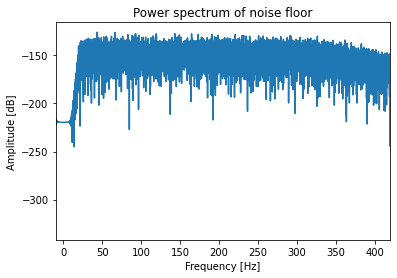

In [221]:
y = df_butter.channel_2.to_numpy()
y = y[100:-100]
N = len(y)
T = 1 / sampling_rate
# x = np.linspace(0.0, 1.0/(2.0*T), N//2)
x = scipy.fftpack.fftfreq(N, d=T)
psd = np.abs(scipy.fftpack.fft(y))**2
idx = np.argsort(x)
fig = plt.figure()
# plt.plot(x, 2.0/N * np.abs(y[:N//2]))
# plt.plot(x, 20*np.log10(np.abs(y)))
plt.plot(x[idx], 20*np.log10(psd[idx]))
plt.xlim(-10, 420)
# plt.ylim(-260, 10)
plt.title('Power spectrum of noise floor')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')

In [183]:
# Comb filter
notch_freq = 50.0     # Frequency to be removed from signal (Hz)
quality_factor = 10.0
b_notch, a_notch = scipy.signal.iircomb(w0=notch_freq, Q=quality_factor, fs=sampling_rate, ftype='notch')
freq, h = scipy.signal.freqz(b_notch, a_notch, fs=sampling_rate)
comb_filter = lambda x: scipy.signal.filtfilt(b_notch, a_notch, x)
df_comb = df_butter.apply(comb_filter, axis=0, raw=True)

N_comb = len(df_comb.index)
x_comb = np.linspace(0.0, 1.0/(2.0*T), N_comb//2)
df_comb_fft = df.apply(scipy.fftpack.fft, axis=0, raw=True)

Text(0, 0.5, 'Amplitude [dB]')

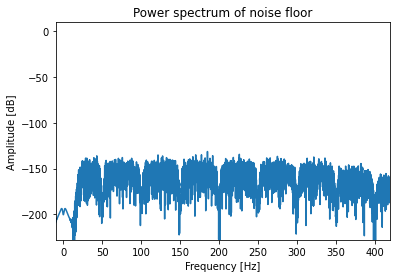

In [184]:
y = df_comb.channel_2.to_numpy()
y = y[100:-100]
N = len(y)
T = 1 / sampling_rate
# x = np.linspace(0.0, 1.0/(2.0*T), N//2)
x = scipy.fftpack.fftfreq(N, d=T)
psd = np.abs(scipy.fftpack.fft(y))**2
idx = np.argsort(x)
fig = plt.figure()
# plt.plot(x, 2.0/N * np.abs(y[:N//2]))
# plt.plot(x, 20*np.log10(np.abs(y)))
plt.plot(x[idx], 20*np.log10(psd[idx]))
plt.xlim(-10, 420)
plt.ylim(-228, 10)
plt.title('Power spectrum of noise floor')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')

In [66]:
# Find noise floor
noise_data = np.load('data/channel_noise_external.npy')
df_n = pd.DataFrame(data=noise_data.T).set_index(0)
df_n = (df_n * v_ref) / resolution
df_n /= gain
df_n.columns = "channel_" + df_n.columns.astype(str)
df_n.index.name = "timestamp"
df_n.index -= min(df_n.index)
df_n.index /= 10**6

noise = df_n.channel_3
noise = noise.to_numpy()
noise = noise - noise.mean()

# Bandpass filter
high = 20        # Remove DC-related noise
low = 400       # EMG harmonics above 400Hz are generally due to noise
b, a = scipy.signal.butter(4, [high,low], btype='bandpass', fs=sampling_rate)
noise = scipy.signal.filtfilt(b, a, noise)

# Comb filter
notch_freq = 50.0     # Frequency to be removed from signal (Hz)
quality_factor = 5.0
b_notch, a_notch = scipy.signal.iircomb(w0=notch_freq, Q=quality_factor, fs=sampling_rate, ftype='notch')
freq, h = scipy.signal.freqz(b_notch, a_notch, fs=sampling_rate)
noise = scipy.signal.filtfilt(b_notch, a_notch, noise)

In [87]:
# Calculate SNR
power_s = 1/(len(df_comb)) * np.abs(df_comb)**2
power_n = 1/(len(noise)) * np.abs(noise)**2
l = min(len(df_comb), len(noise))
power_s = power_s[:l]
power_n = power_n[:l]
snr = 10*np.log10((np.abs(power_s - power_n))/power_n)      # SNR in dB
snr.mean()

ValueError: Unable to coerce to Series, length must be 8: given 79906

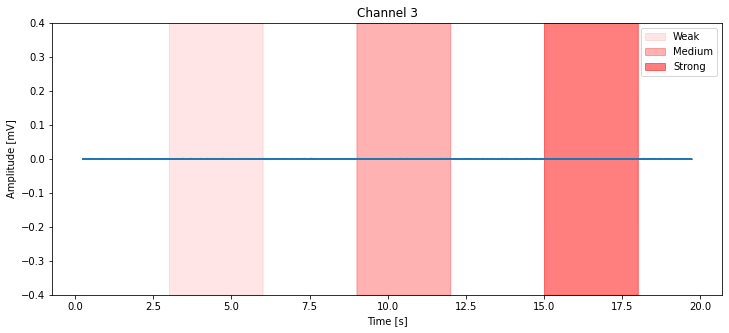

In [83]:
# Plot single channel
d = df_comb.iloc[1000:-1000]
fig = plt.figure(figsize=(12,5))
plt.plot(d.channel_3*1000)
plt.ylim(-0.4, 0.4)
plt.title('Channel 3')
plt.ylabel('Amplitude [mV]')
plt.xlabel('Time [s]')

timestamps = d.index.to_numpy()
flex1 = np.zeros_like(timestamps)
flex2 = np.zeros_like(timestamps)
flex3 = np.zeros_like(timestamps)
flex1[(timestamps > 3) & (timestamps <6)] = 1.0
flex2[(timestamps > 9) & (timestamps <12)] = 1.0
flex3[(timestamps > 15) & (timestamps <18)] = 1.0

plt.fill_between(timestamps, flex1*0.4, -flex1*0.4, color="red", alpha=0.1, label="Weak")
plt.fill_between(timestamps, flex2*0.4, -flex2*0.4, color="red", alpha=0.3, label="Medium")
plt.fill_between(timestamps, flex3*0.4, -flex3*0.4, color="red", alpha=0.5, label="Strong")
plt.legend()


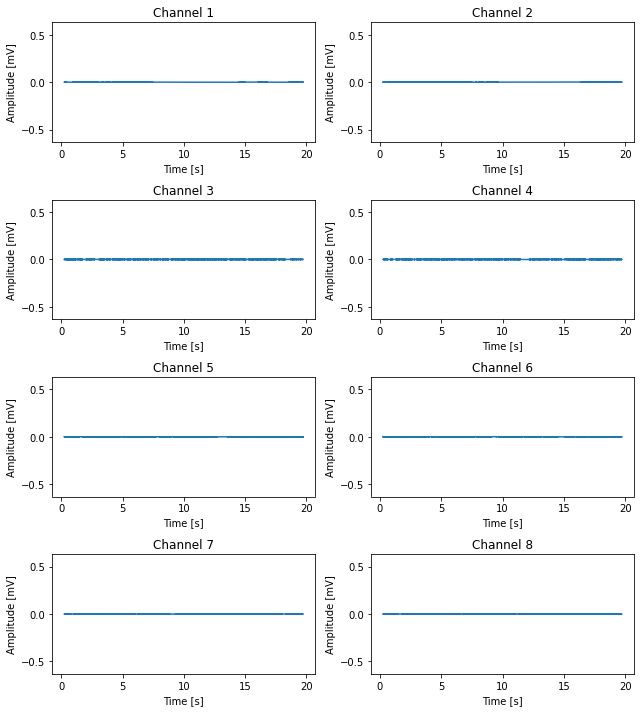

In [84]:
# Plot channels
plt.figure(figsize=(9,10))
for i, c in enumerate(df_comb.columns):
    plt.subplot(4, 2, i+1)
    df_comb[c].iloc[1000:-1000].multiply(1000).plot()
    plt.ylim(-0.63, 0.63)
    plt.title('Channel ' + str(i+1))
    plt.ylabel('Amplitude [mV]')
    plt.xlabel('Time [s]')
plt.tight_layout()

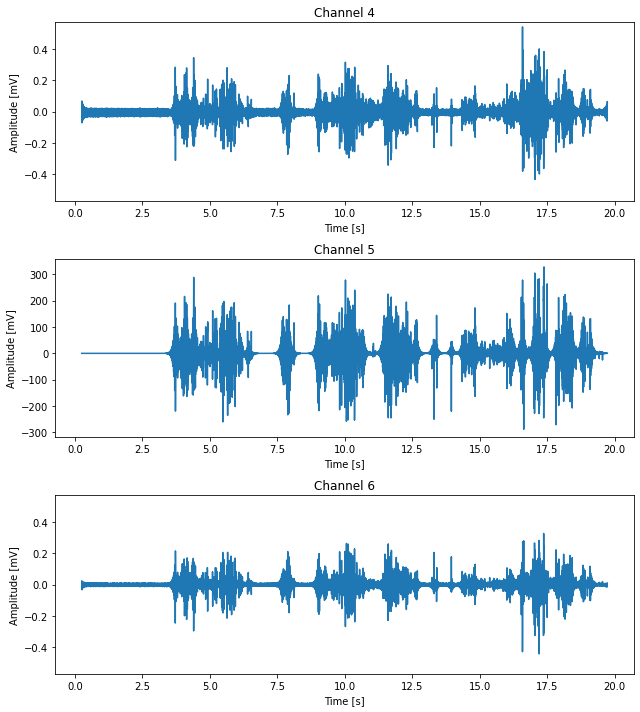

In [76]:
fig = plt.figure(figsize=(9,10))
plt.subplot(3, 1, 1)
plt.plot(d.channel_4*1000)
plt.ylim(-0.57,0.57)
plt.title('Channel 4')
plt.ylabel('Amplitude [mV]')
plt.xlabel('Time [s]')
plt.subplot(3, 1, 2)
plt.plot(d.channel_5*1000)
plt.title('Channel 5')
plt.ylabel('Amplitude [mV]')
plt.xlabel('Time [s]')
plt.subplot(3, 1, 3)
plt.plot(d.channel_6*1000)
plt.ylim(-0.57,0.57)
plt.title('Channel 6')
plt.ylabel('Amplitude [mV]')
plt.xlabel('Time [s]')
plt.tight_layout()

ValueError: x and y must have same first dimension, but have shapes (39984,) and (79968, 8)

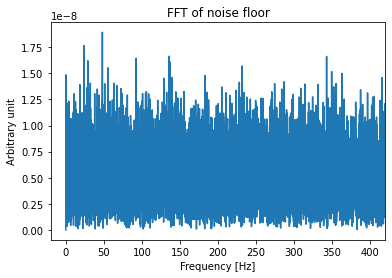

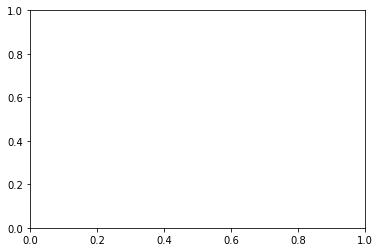

In [93]:
# FFT Plots

fig = plt.figure()
plt.plot(x_butter, 2.0/N_butter * np.abs(df_butter_fft.channel_1.iloc[:N_butter//2]))
plt.xlim(-20, 420)
# plt.ylim(-1e-7, 9e-6)
plt.title('FFT of noise floor')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Arbitrary unit')

fig = plt.figure()
plt.plot(x_comb, 2.0/N_comb * np.abs(df_comb_fft[:N_comb//2]))
plt.xlim(-20, 420)
# plt.ylim(-1e-7, 9e-6)
plt.title('FFT of noise floor after comb filtering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Arbitrary unit')